**&copy; CentraleSupélec.  
For any question, contact the author at frederic.pennerath@centralesupelec.fr**

<h1>
<font size="30">Spam versus ham</font>
Naive Bayes for spam detection
</h1>


## Objectives

Despite the title, studying and testing *Naive Bayes* is only a secondary objective of this first labwork as this method is often too elementary and can be advantageously replaced by more sophisticated methods.
This labwork has actually two more important objectives:  
The first goal is to ensure, before going further, that you all have a basic knowledge and practice of the standard Python libraries & tools that are the most widely used in Data Science. They are:
  - [numpy](https://numpy.org/) for numerical computation on multidimensional arrays (similar to Matlab).
  - [matplotlib](https://matplotlib.org) for plotting various graphs.
  - [scikit-learn](https://scikit-learn.org) as the standard machine learning Python library, that not only provides off-the-shelf ML methods but also standard generic tools & methods like cross validation, etc.
  - [pandas](https://pandas.pydata.org) for manipulating tabular datasets similarly to a database (operations like indexing, filtering, sorting, join, etc), but in memory (so it does not suit processing of really big datasets).
  - [seaborn](https://seaborn.pydata.org/), maybe less importantly than the others, is a statistical data visualization library extending ``matplotlib`` to easily provide various statistical views of your dataset (descriptive statistics).
  - [jupyter](https://jupyter.org) is a service to write interactive notebooks in different languages (including Python). This is presently what are your are using. Jupyter is largely used by data scientists to prototype some code, iteratively explore data or build tutorials. Once your code works, you better make a real module from your notebooks.

While all these libraries put all together are still not as rich as **R** (the preferred language of statisticians) for analyzing data, the Python ecosystem has the advantage to have many other libraries in all fields of application of computer science. For this reason, Python is more versatile than **R** and is the preferred choice in data science.


The second goal is to illustrate some basic aspects of data analysis, including:
  - Illustrating how a typical scenario handling data looks like (data cleansing, preprocessing & data analysis, model estimation, model evaluation then looping back to preprocessing again) based on scikit-learn, pandas & seaborn.
  - Mentionning some beginner's traps.
  - Presenting some practical aspects of classification: imbalanced classes and ROC AUC, cost sentitive classification, uncalibrated probabilities, etc
  - How sometimes one must write some code to overcome the limitations of out-of-the-box algorithms.
  


## Subject

The labwork is a very classical application of Naive Bayes to address the problem of *spam detection*.
*Spam messages* are massively sent and unwanted messages that one wishes to discard whereas *ham messages* are the remaining messages that should be kept.
The term *Spam* and its relation with pork meat *ham* comes from a brand of canned cooked pork that is reused in a Monty Python sketch where all the meals in a restaurant tirelessly contain Spam.

We consider here spam detection in textos (SMS) which are different from emails, as these text messages are much shorter, written in informal and sometimes slang or cryptic language with many abbreviations.
Because this classification problem is relatively simple, Naive Bayes is a good choice as it is robust (no risk of overfitting even in small N large M problems like here), fast and simple to implement. See lectures to see how Naive Bayes works.

Naive Bayes takes as input a set of monovalued features modelled by some univariate categorical or continuous distributions. 
Therefore to apply Naive Bayes to textual data, these texts have to be modelled as *bags of word*, i.e. as a large vector where each of its components represents a given word.
We therefore work with a very high dimensional space whose size is the number of words in our vocabulary.

## Recommendations

Of course for the labwork to be useful you must try to answer the questions by yourself.
However if you are stuck or some question looks unclear, you might have a look at the provided solution that is
the ``SMS_spams_solution.ipynb`` notebook.



For those that have never used Jupyter, here are the main things to know:
- A notebook is made of cells. Each cell can be a *code cell* containing runnable Python code, or a *Markdown cell* to contain textual infomation. The category of the selected cell is displayed in the dropdown menu on the Jupyter menu bar. Note that you can change this category.
- If you want to edit the content of code or text cell, just double click on it.
- To validate and run a code or Markdown cell, you must first select it and then press **CTRL + ENTER** to run it. The results (prints, etc) should appear below the cell. Pressing **SHIFT + ENTER** is almost the same but in addition, it jumps to the next cell.
- Use the **Cell menu** to run all cells above or below.
- Use the **Kernel menu** to restart from scratch if you entered some bad state or were getting lost.



So let's start. First step is to import the classical modules by running the cell below.
If you have installed correctly your packages (check the README file), you shouldn't get any error message.

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# This magic function call automatically calls plt.show() for you when drawing some plots.
%matplotlib inline

# Data preprocessing: check, load and cleanse

## Check the data

Then the next thing to do is to look at the provided dataset ``SMS_spams.txt`` using command-line instructions like ``head``, ``tail`` or ``wc -l`` (on Unix systems at least) to understand its structure and size.

*Note that you can directly call shell commands from Jupyter by prefixing with ``!`` like for instance ``!ls`` as shown below. However these commands are intended to check files quickly from a terminal and not as from a Jupyter notebook as they are not portable from one OS to another.*

In [181]:
!ls

README.txt	  SMS_spams.ipynb	    SMS_spams.txt
requirements.txt  SMS_spams_solution.ipynb


In [182]:
!tail SMS_spams.txt

ham	Ok lor... Sony ericsson salesman... I ask shuhui then she say quite gd 2 use so i considering...
ham	Ard 6 like dat lor.
ham	Why don't you wait 'til at least wednesday to see if you get your .
ham	Huh y lei...
spam	REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode
spam	This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.
ham	Will ü b going to esplanade fr home?
ham	Pity, * was in mood for that. So...any other suggestions?
ham	The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free
ham	Rofl. Its true to its name


In [183]:
!wc -l SMS_spams.txt

5574 SMS_spams.txt


## Load the data

Once you understand the way the file is formatted, you have to build from it a in-memory representation (as the data are rather small) of the bags of words.

We typically distinguish:
* the classes (spam or ham) that we can representy concisely by a numpy 1D-array Y (with 0 for ham and 1 for spam)
* the bags of words that can be represented by a numpy 2D-array X whose columns represent one given word and whose rows represent the different messages. 

However we'd better store X as a *Pandas dataframe*: dataframes index every column and row with a specific value, that can be a name (string). These indexes in turn allow fast access to rows and columns and efficient operations on it like filtering, joining, sorting, etc.
For our application, dataframes are also very convenient here compared to numpy arrays as every column (and these are many here) can be mapped to a header or "title name" (in fact, the index entry), that is the word of the vocabulary mapped to the column.

Below is a faked toy example of data to build a spam detector for baby sentences. It shows you how to create a numpy array, a Pandas dataframe and how to insert a 1D-array into an existing dataframe.

In [184]:
# Python list of considered words
words = ['mum', 'dad', 'broumm', 'babbling']

# This numpy array will contain the counts as produced by the scikit-learn vectorizer.
counts = np.array([
    [ 3, 0, 0, 1], # Baby 1
    [ 0, 0, 0, 8], # Baby 2
    [ 4, 0, 0, 0],
    [ 1, 0, 0, 0],    
    [ 0, 0, 3, 1]
])

# Class for every baby: 0 is ham (meaning: "I need something"), 1 is spam (meaning: "Making noise is fun!")
Y = [0, 1, 0, 0, 1] 

# Builds a dataframe with word features
X = pd.DataFrame(data = counts, columns = words)

# Add the class as the first column
X.insert(0, '#class#', Y)

# Print the heading lines
X.head()

,#class#,mum,dad,broumm,babbling
0,0,3,0,0,1
1,1,0,0,0,8
2,0,4,0,0,0
3,0,1,0,0,0
4,1,0,0,3,1


While ``pandas`` supports many load functions for various formats (like ``read_csv``, ``read_json``, ``read_excel``, etc), the idea here is to preprocess directly the file by reading every line (this is very easy in Python) and convert it into a bag of words.

Because this is a specific treatment, the best solution is to develop your own function to load the dataset and vectorize it. 
To do so, you can use the scikit-learn object ``CountVectorizer`` as illustrated [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).  

**Question:**  
Try to implement by yourself the Python function ``vectorize_dataset(filename)`` provided below, that:
* reads the lines of the file one by one and feed a ``CountVectorizer`` with them. In order to reduce the number of features, we will drop non-informative words, called *stop words*, by passing argument ``stop_words='english'`` to the vectorizer constructor.
* outputs a dataframe similar to the one of the baby example along with the array of messages.

Help yourself by using GIYF (Google is your friend), tutorials, FAQ like [https://stackoverflow.com/](https://stackoverflow.com/), official documentation website [docs.python.org](https://docs.python.org/), etc.

If you are beginner in Python, analyze the ``read_dataset`` function provided below that parses line by line the dataset to print the class and the length of every message.
By adapting this function, introducing the vectorizer and following the baby example to produce the dataframe, you should be able to make it.

Whether you choose the hard or the easy way, don't forget to test seriously before going further.

In [185]:
# Import regular expressions
import re

def read_dataset(filename):

    # Compile the regular expression once and for all
    expr = re.compile('\s+')
    list_word = [];
    list_target =[];
    
    # Read the file line by line
    with open(filename) as f:
        for i,line in enumerate(f):
            
            # Separate class from textual words
            splits = expr.split(line, 1)
            
            # Check the line structure
            
            if(len(splits) < 2):
                #print(f'Bad syntax for {i+1}th line: "{line}"')
                pass
            else:          
                      
                target, msg = splits
                list_word.append(msg.rstrip())
                list_target.append(int(target == 'spam'))
                #print(f"{target:4} | {len(msg)}")
        return list_word,list_target
    

In [186]:
read_dataset('SMS_spams.txt')

(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  'Ok lar... Joking wif u oni...',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
  'U dun say so early hor... U c already then say...',
  "Nah I don't think he goes to usf, he lives around here though",
  "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
  'Even my brother is not like to speak with me. They treat me like aids patent.',
  "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
  'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',


In [187]:
# Import regular expressions and vectorizer
import re
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_dataset(filename):
    counts = None # Pandas dataframe containing classes and word counts (see toy example)
    messages = [] # List of text messages
    
    # Complete code here
    messages,target = read_dataset(filename)
    count_vecteur = CountVectorizer(stop_words='english')
    X = count_vecteur.fit_transform(messages)
    words = count_vecteur.get_feature_names_out()
    counts = pd.DataFrame(columns=words,data = X.toarray())
    counts.insert(0,"#class#",target)
    return counts, messages

In [188]:
df, messages = vectorize_dataset('SMS_spams.txt')
print(f"Number of words = {len(df.columns)}")
df.head()

Number of words = 8445


,#class#,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cleanse the data

One you have loaded your data into a Pandas dataframe, the next step is to *cleanse the data*, i.e. to delete or to fix all entries or columns that are obviously wrong or unexploitable.

A typical beginner's mistake made at this stage is to over-zealously modify the original data set.
This introduces bias into the data and eventually does more harm than good.
Here is an example of deleting "empty" entries.

### "Empty" messages. Delete or not delete?

We want to see if there exists "empty" messages containing only stop words or unrecognized words.

**Question:**  
Extract the row index from the Pandas dataframe that correspond to messages containing no keywords, only stopwords (i.e. all its word counts are zero).

*This is an exercise for manipulating Python lists, numpy arrays and Pandas dataframes.
Don't forget to avoid as much as possible explicit loops written in Python as they are slow. It is much faster to replace them by calls to **Numpy** or **Pandas** functions that are implemented in optimized C/C++.
You can use function ``print_messages`` below to display the messages of the selected index.* 

*Don't spend too much time on this question. If you don't find, check the proposed solution (only one way among many to do it).*

In [189]:
def print_messages(indexes):
    classes = ['ham', 'spam']
    rows = df.iloc[indexes,:]
    for i, cat in zip(indexes, rows['#class#']):
        print(classes[cat], "|", messages[i])

In [190]:
# Compute the indexes of messages containing only stopwords

indexes = [0,5]

# Now print the results
print_messages(indexes)

ham | Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
spam | FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


**Question:**  
How should we manage these lines without keywords? Should we drop them? Or add more words to the vocabulary?
Write some special bypassing code treatment?


In [191]:
# Stop words are not very usefull in our subject so we can drop them, more over we have enaugh data to tain our model 

### Non-English words. Delete or not delete?

It also seems many words are not English vocabulary, like abbreviations, smileys, words with special characters, etc. What we should do about them? Should we delete messages containing these unrecognized words? 
Clearly no, for the same reason as above.

But should we remove every column which does not match an English word? Or should we keep it as it is?

There is no simple answer. This really depends on the meaning of these special words.
Let's see how many they are and how they look like.

**Question:**  
Print the list of words that contain at least one non alphabetical character.

*To do this, you will need to access to the dataframe column index, given by the ``columns`` attribute.
You might also take advantage of the method ``s.isalpha()`` that returns a boolean that is true if string ``s`` only contains alphabetical characters.*

In [192]:
def non_english_word(df):
    words= df.columns
    list_non_english =[word for word in words if not word.isalpha()]
    list_non_english.pop(0)
    return list_non_english
list_non_english= non_english_word(df)

Many non alphabetical words contain numbers. These numbers can carry some information (phone numbers either free or pay phone numbers, or other words like "nokia6600", both suggesting spam) or not (like words "10", "8am", "2nd", etc).

The first category is something to exploit as an opportunity to do some *feature engineering*, that is, one can inject application domain knowledge to improve classifier's performance, by building new informative features that will indicate whether messages contain relevant word categories:
- phone numbers, either free, pay phone or private numbers
- proper nouns of persons, companies, countries, regions, cities, etc

The second category is seemingly harmless, but is in fact very harmful if left unattended.
This is because these words are both noisy (i.e. independent of the class) and very rare.
For example, the number of messages containing 177 may be 1 or 2. Therefore, estimating the probability ``P("message contains 177" | "message is a spam (or a ham)")`` using the default *MLE* estimator is nonsense.

To circumvent this problem, we have seen during the lectures how to replace MLE by a regularized *MAP estimator* or by *Bayesian inference* which is even better. Both approaches amount to assume a *Beta prior* over probability of observing a given word in a spam or a ham message. The chosen Beta prior $Beta(\alpha,\beta)$ will typically promote a uniform distribution: for instance taking $\alpha = \beta = 4$ will assume 3 faked spams and 3 faked hams for every word). This would be a sound option.

However we already know that most raw numbers are not informative with respect to the class.
So it is better to just delete these words, and by the way, save some computational time by reducing substantially the number of columns.

**Question:**  
Remove the columns from the dataframe corresponding to non-alphabetical words.
To drop columns, use the ``drop`` pandas method (check the online documentation).

In [193]:
df_copy =df

In [194]:
def drop_columns(df,list_drop):
    df.drop(list_drop,inplace=True,axis=1)
    return df
df_copy = drop_columns(df,list_non_english)

## Analyse the data

It's now time to look a little more closely the data and do some more statistical *sanity checks*:
- Look at target distribution (how many classes, how balanced they are, etc)
- Look at histograms of categorical & moments of numerical features (e.g use ``pd.describes()``)
- Check for outliers, duplicates, etc
- Remove useless features (columns with a lot of missing values or constant, etc) or remaining overspecific features (ids, etc)

### Duplicated messages. Delete or not delete?

Let's first look at duplicates using pandas method ``duplicated``. 

**Question:**  
Are there many of them? What shoud we do with these? Remove or keep duplicates?

In [195]:
index_duplicated = df_copy.duplicated()
print(df_copy[index_duplicated==True].columns)


Index(['#class#', 'aa', 'aah', 'aaniye', 'aaooooright', 'aathi', 'ab', 'abbey',
       'abdomen', 'abeg',
       ...
       'zed', 'zeros', 'zhong', 'zindgi', 'zoe', 'zogtorius', 'zoom', 'zouk',
       'zyada', 'èn'],
      dtype='object', length=7320)


**Answer:**  
It depends but like for messages with only stop words, the answer should be the result of some reflexion. 

Duplicates here are not artifacts (like redundant entries in a database because a sample has been collected multiple times).
Here they are real duplicates, that is, identical messages sent several times.
A duplicate is therefore more likely a spam. This is an interesting piece of information we should try to exploit.

However if we don't add any extra feature, we won't have access to this information when processing message since, when our spam detector receives a new message, it does not know if this is a duplicate as it does not archive the history, i.e. all previous messages.
In that case, keeping duplicates might be a bad idea as it might just increase the influence of some very duplicated messages in the training (and even test) dataset that won't occur in operation, on the long term (spams have generally a short life).

If we decide to keep the history, then we can add a new feature to a message, that is the number of times identical or very similar messages have been previously received.


To keep it simple, one choose the easy way: 

**Question:**  
Remove the duplicates using pandas method ``drop_duplicates()``. Check the size of your new dataset.
Then look at the class distribution using method ``value_counts()`` of pandas series.

In [196]:
df_copy =df_copy.drop_duplicates()

In [197]:
df_copy["#class#"].value_counts(normalize=True)

0    0.887003
1    0.112997
Name: #class#, dtype: float64

Let's check now the distribution of words.

**Question:**  
Plot the distribution of the number of occurrences of words using the dataframe method ``sum()``, the numpy function ``np.histogram()`` and the matplotlib function ``plt.bar()``.
What do you conclude?

0.8326232501521607

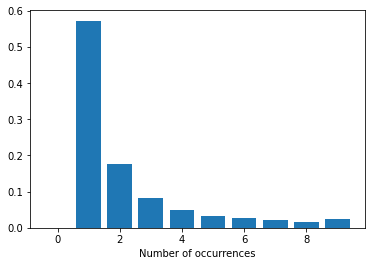

In [198]:
occurrences = df.sum()
counts, bins = np.histogram(occurrences, bins=range(11), density=True)
plt.bar(np.arange(len(counts)),counts)
plt.xlabel('Number of occurrences')
np.sum(counts[:4])

### The Zipf's law

**The next question is subsidiary and should be done at the end of the labwork, only if you have time.**

The [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) is a *heavy-tailed distribution* that models particularly well the distribution of the frequency of words in many natural languages, since in most languages, very few words have a high frequency and many words have a very low frequency.

The Zipf's law considers the relative frequencies $f(w)$ of every word $w$ observed in a large text corpus. Assuming words $(w_i)_{1\leq i \leq N}$ are sorted in decreasing order of their frequency, the Zipf's law states that 
$$f(w_i) \approx \frac{1}{K\,i^s}$$
for some $s > 0$ and some normalization factor $K$ such that the frequencies sum to one.

**Question:**  
Compare the distribution of words in textos with Zipf's law. To this end, find the optimal values for $K$ and $s$ such that the corresponding Zipf's law best matches $i \mapsto f(w_i)$. 

**Indication:**  
Taking the logarithm of the expression, we get a linear expression
$$\log f(w_i) \approx - \log(K) - s \, \log(i)$$
We can thus determine the coefficients $\log(K)$ and $s$ using an ordinary linear regression (using `stats.linregress`).

## Preprocess the data for scikit-learn

Last preprocessing step before applying Naive Bayes is to transform data so that they can be processed as inputs by ``scikit-learn`` methods.
On this aspect, ``scikit-learn`` appears not to be very flexible.
In particular many methods cannot directly process categorical variables. 
These variables must first be converted to boolean vectors using *one-hot encoding*.
Note that this is not anymore the case for Naive Bayes that supports such distribution now.

But in general when working with ``scikit-learn``, you must:
1. Encode the target class feature as consecutive integers (using class ``LabelEncoder`` if needed)
2. Depending on the method you might need,
  * Separate the categorical and numerical features,
  * One-hot encode categorical features  
3. Extract classes into a numpy 1D-array (denoted usually Y) and features as a 2D-array (denoted usually X)

Hopefully here classes and features can be processed as binary variables: 
While the value of an input feature is the number of occurrences of the word it represents in a document, the implementation of Bernoulli Naive Bayes in scikit-learn interprets such features as binary: 1 if the count is non null, 0 otherwise. As a consequence, steps 1 and 2 are useless ; you just need to do step 3 as following:

In [199]:
Y = df['#class#'].values
X = df.iloc[:,1:].values

In [200]:
print(Y.shape)
print(X.shape)

(5574,)
(5574, 7319)


# Try Naive Bayes

Scikit-learn's implementations of NB suffers from several limitations:
- Only normal distribution is supported for continuous variables.
- And the worst thing: **All features are assumed to be of the same family (either Bernoulli, multinomial or Gaussian)**.

So let's see what can be achieved given these restrictions.

## Simple cross validation

**Accuracy** is the standard classification score.
However in presence of imbalanced classes, the **area under the ROC curve** (ROC AUC) is more appropriate to assess the classifier robustness (see lecture on this topic).
Finally in order to take into account the higher cost of false positive (spammed ham) compared to false negative (undeleted spam), one proposes the **average cost** as a third score. 

*scikit-learn* expects to instantiate a classifier object. When passed to the cross validation (thanks to function ``cross_validate``), a clone of this object (not the object itself) is trained on every fold to avoid any cross-border effect.
In the following we will use the ``BernoulliNB`` class that can be straight-forwardly applied to our binary features. See its [documentation](https://scikit-learn.org/stable/modules/naive_bayes.html). In particular the classifier constructor accepts as argument an argument ``alpha`` that is a pseudocount (i.e ``alpha`` is equal to $\alpha - 1$ where $\alpha$ is the hyperparameter of the symmetrical Beta distribution $Beta(\alpha,\alpha)$ used as a prior for the Bernoulli probabilities).

**Question:**  
Complete the code below to evaluate the method on our data, according to accuracy and AUC (see the ``scoring`` argument of function ``cross_validate``). Save the results in a pandas dataframe as shown on the code snippet.
What's your conclusion?

In [201]:
from matplotlib.offsetbox import bbox_artist
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB

# Create a BernoulliNB classifier 
BernoulliNB_classifier = BernoulliNB()
scoring_functions = {'acc' : 'accuracy', 'auc': 'roc_auc'}
# Cross-validate it, computing accuracy and auc on every fold
BernoulliNB_result = cross_validate(BernoulliNB_classifier,X,Y,cv=3,scoring=scoring_functions)
# Compute the average accuracy and auc
acc= BernoulliNB_result["test_acc"].mean()
auc = BernoulliNB_result["test_auc"].mean()
# Save results in a dataframe, using line below.
scores = pd.DataFrame(data={'classifier': ['Bernoulli NB'], 'acc': [acc], 'auc': [auc]}, columns=[ 'classifier', 'acc', 'auc'])
scores.head()

,classifier,acc,auc
0,Bernoulli NB,0.967528,0.986565


## Poor probability calibration of Naive Bayes 

Without further optimization, Naive Bayes already produces an excellent accuracy and AUC.
However this does not tell us whether the class probabilities produced by Naive Bayes are well calibrated.

To do so, we won't use cross validation here but instead we will split the dataset in two equal parts, one for training, the other for testing (evaluation). *scikit-learn* provides the function ``train_test_split`` for this purpose.

**Question:**  
Create a brand new classifier (to avoid cross-border effect) and train it on the first half using the ``fit`` method. Then output class probabilities on the test dataset using the ``predict_proba`` method and display the distribution of the probability for messages to be a spam. What do you conclude?

One can use the visualization library *Seaborn*, in particular its ``displot()`` function (one recommends here to use the option ``kind='kde', bw_adjust=0.1``).

[0 0 0 ... 0 0 0]


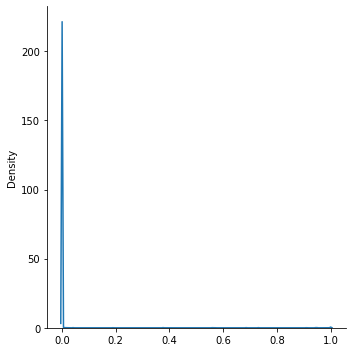

In [202]:
from sklearn.model_selection import train_test_split
BernoulliNB_classifier_2 = BernoulliNB()
# Split train and test dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)
# Fit a BernoulliNB model on the train dataset
print(y_train)
BernoulliNB_classifier_2.fit(X_train,y_train)
y_pred = BernoulliNB_classifier_2.predict_proba(X_test)
result = BernoulliNB_classifier_2.score(X_test,y_test)
# Output class probabilities on the test dataset using method predict_proba()
# Call seaborn displot on the probability vector of class spam
sns.displot(y_pred[:,1], kind='kde', bw_adjust=0.1)


## Calibration of output distributions

Imagine a binary classifier that is evaluated on a test dataset of $n$ samples. For every sample $i \in \{1 \dots n\}$, it outputs a probability $p_i$ that this sample is a member of class 1.
Let us consider some interval of probability, like for instance interval $I = [0.5, 0.7]$.
Let us define the number $n_I$ of samples whose probability $p_i$ is within interval $I$. Among these $n_I$ samples, let denote $n_I^1 \leq n_I$ the number of positive examples. We then expect that fraction $\frac{n_I^1}{n_I}$ will be roughly equal to $0.6$ and clearly between 0.5 and 0.7. Same for any other interval containing sufficiently many samples to make a reliable estimation. If this is true, we say that the classifier is *well calibrated*.

However this is rarely the case. For instance, we just saw that Naive Bayes outputs extreme probabilities close to 0 or 1. If such a classifier was well calibrated, this would imply an accuracy of 1 but this is obviously wrong.

### Calibration plot

One way to check whether a classifier is well calibrated, is to plot a *calibration plot*: it consists in partitioning regularly interval $[0,1]$ into $k$ subintervals $I_i = [(i-1)/k, i/k]$ and then plotting for each subinterval $I_i$ the ratio $n_{I_i} / n$. We except the plot to be close to the main diagonal.

**Question:**  
Use the scikit-learn function ``sklearn.calibration.calibration_curve`` to draw the calibration plot.

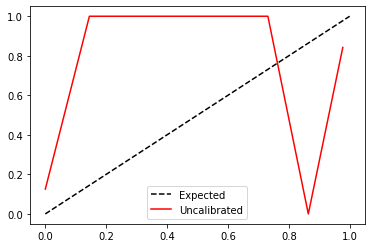

In [203]:
from sklearn.calibration import calibration_curve

# Call calibration_curve function on the test dataset using 10 bins (intervals)
prob_true,prob_pred = calibration_curve(y_test,y_pred[:,1],n_bins=10)
# Plot the result using matplotlib plot function
plt.plot([0,1],[0,1], 'k--', label='Expected')
plt.plot(prob_pred,prob_true, 'r-', label='Uncalibrated')
plt.legend()

**Question:**  
Interpret this plot by running the code below. Why the classifier is badly calibrated?

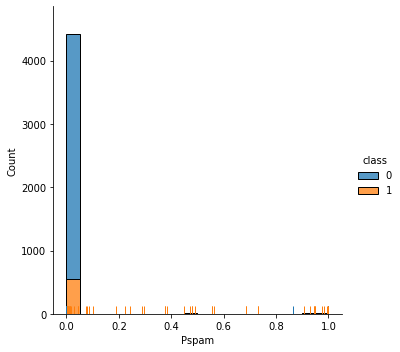

In [206]:
def plot_spam_prob(probs):
    '''
    Plots the histogram of the spam probability with the class (colored ticks on the x-axis) mapped to every example
    '''
    Pspam = pd.DataFrame({'class': y_test, 'Pspam': probs[:,1]})
    sns.displot(data=Pspam, x='Pspam', bins=20, hue='class', rug=True, multiple='stack')

# We assume probs is the numpy array returned by the predict_proba() method
plot_spam_prob(y_pred)

As expected, the calibration plot has a poor quality. Because intermediate probabilities (i.e not equal to 0 or 1) are mostly ambiguous spams (spams that look like hams), the calibration plot is clearly above the diagonal.
However we see here another problem: many spams are classified as hams with a very low probability $P(Y=\text{spam}\,|\,X)$. This will be the main source of error.

### Classifier calibration

Calibration is the process of adjusting the output distributions of a badly calibrated model (a classifier or a regressor) in order for the resulting probabilities to be closer to the true probabilities.
Different calibration methods are implemented in scikit-learn (isotonic regression or fitting a sigmoid).

**Question:**  
Complete the code below by using class ``sklearn.calibration.CalibratedClassifierCV`` to calibrate your classifier, using the `isotonic` method. Compare the calibration plots of both uncalibrated and calibrated models.

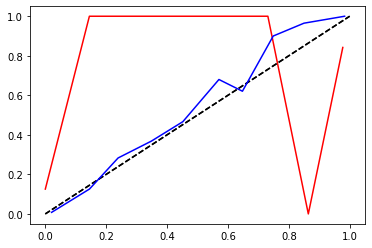

In [213]:
from sklearn.calibration import CalibratedClassifierCV

# Ideal calibration curve
plt.plot([0,1],[0,1], 'k--', label='Expected')

# Plot the calibration curve for the uncalibrated Naive Bayes
clf1 = BernoulliNB(alpha=1)
clf1.fit(X_train, y_train)
probs1 = clf1.predict_proba(X_test)

frac_pos, mean_probs =  calibration_curve(y_test, probs1[:,1], n_bins=10)
plt.plot(mean_probs, frac_pos, 'r-', label='Uncalibrated')
# Plot the calibration curve for the calibrated Naive Bayes

# Complete the code from here

# First create a CalibratedClassifierCV based on Naive Bayes (see scikit-learn documentation)
CalibratedClassifierCV_classfier = CalibratedClassifierCV()
# Then fit it on train and estimate probabilities of spam on test
CalibratedClassifierCV_classfier.fit(X_train,y_train)
y_pred_caliber = CalibratedClassifierCV_classfier.predict_proba(X_test)
# Finally plot the result on top of the previous plot
plt.plot([0,1],[0,1], 'k--', label='Expected')

# Plot the calibration curve for the uncalibrated Naive Bayes
frac_pos, mean_probs =  calibration_curve(y_test, y_pred_caliber[:,1], n_bins=10)
plt.plot(mean_probs, frac_pos, 'b-', label='Calibrated')


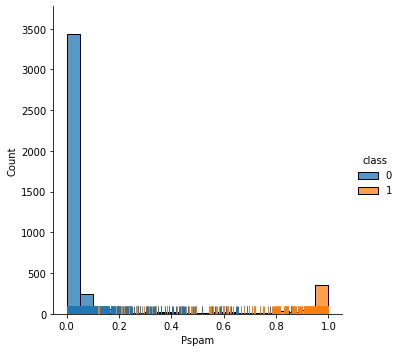

In [214]:
plot_spam_prob(y_pred_caliber)

## ROC curves

ROC curves are a tool to represent graphically the behaviour and performance of a binary classifier (see lecture notes) independently of the class ratios in the dataset. *Scikit-learn* provides function ``plot_roc_curve`` to easily plot the roc curve estimated on a test dataset.

**Question:**  
Compare the roc curves of calibrated and uncalibrated Naive Bayes. Are these curves good? Why there is no much difference?

/home/mraillat/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/mraillat/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


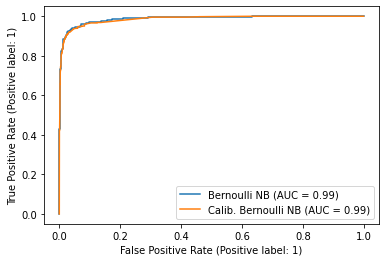

In [215]:
from sklearn.metrics import plot_roc_curve

# Split data into a train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6)

# For each classifier (uncalibrated and calibrated Bernoulli NB) trained on the train dataset,
# plot the ROC curve calling plot_roc_curbe on the test dataset

clfs = {
    'Bernoulli NB': BernoulliNB(alpha=1),    
    'Calib. Bernoulli NB': CalibratedClassifierCV(BernoulliNB(alpha=1), cv=10, method='isotonic'),
}

fig, ax = plt.subplots()

for name,clf in clfs.items():
    clf.fit(X_train, Y_train)
    plot_roc_curve(clf, X_test, Y_test, name=name, ax=ax) 

There is no much difference as the calibration has mostly impacted the very few spam messages whose uncalibrated probability was between 0 and 1. The main problem remains the spams with a low estimated probability to be a spam.
The calibration helps to fix the distribution of probabilities but cannot make miracles by separating badly classified examples.

## Some disgression about feature selection

Another application of Naive Bayes is to score features according to their predictive power.
It can be used for feature selection or just to have some insights about the problem.

The discriminant power of every feature is expressed by their *log-odd* defined as:

$$
\DeclareMathOperator{\logodd}{log-odd}
\logodd(X) = \log \left(\frac{P(Y=1 | X=1)}{P(Y=0| X=1)}\right) = \log\left(P(Y=1 | X=1)\right) - \log\left(P(Y=0 | X=1)\right) 
$$
These log-odds can be computed from the learnt parameters (applying Bayes'rule).
The log-odd of a word $X$ is large (resp. small) if $X$ is characteristic of class $1$ (resp. $0$) and not of class $0$ (resp. $1$).

Once  a  scikit Bernoulli classifier has learnt its parameters from some data (using the ``fit`` method), it provides the log-odds thanks to its ``feature_log_prob_`` attribute.

**Question:**  
Look at the attribute `feature_log_prob` (shape and meaning) of a Naive Bayes model trained on the whole dataset.
Compute from it the log-odds and display the 20 top words characteristic that are most representative of spams and hams respectively.

In [ ]:
# Train a NB model on the whole dataset

# Look at feature_log_prob_ attribute

In [ ]:
# Compute the log-odds from the log_prob_ array
logodds = None

# Rank the features using np.argsort
rankedFeatures = np.flip(np.argsort(logodds))
keywords = df.columns[1:]

# Create a dataframe containing the names of ranked features and their log-odd
rankedKeyWords = pd.DataFrame(data=logodds[rankedFeatures], index=keywords[rankedFeatures], columns=['log-odd'])

In [ ]:
# Print the top-K keywords using the Dataframe head method


**Now look at characteristic words of ham:**

## Cost sensitive classification

Naive Bayes provides as outputs class distributions, even if they are poorly calibrated.
We can therefore design from that a cost sensitive classifier (see lectures).

To evaluate it, one first needs to consider a third additional measure that is the average cost.
In the following, one will assume that a false spam has a cost $c_{fs}$ of 1 while a false ham has a cost $c_{fh}$ of 0.1.
This way we expect an average cost between 0 and 1.
To add this home-made scoring function, we will use functions ``make_scorer`` and ``confusion_matrix``. See documentation [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) to understand how to use it.

To make our classifier cost sensitive, one has to produce as output, the class that minimizes the average cost according to the class distribution it predicts, given some input. 

**Question:**  
For some message $X$, let denote $\hat{y}$ the class ham or spam that provides the smallest expected loss $L(Y,\hat{y})$ when $Y$ follows the distribution $P(Y\,|\,X,\theta)$ output by the classifier.
Determine the mathematical condition to decide whether $\hat{y}=0$ (ham) or $\hat{y}=1$ (spam).

We now want to make our classifier cost-sensitive.
The function `min_expected_cost()` computes the expected cost of a classifier.
This function is registered as a new "scorer" to the cross validation procedure using the *Scikit-learn* function ``make_scorer``.
To work function `min_expected_cost()` needs to call the function `choose_best_class()` that decides which class is the best given the probability of a message to be a spam.

**Question:**  
Once you have completed the body of function `choose_best_class()`, run the code to evaluate this new (negative) score. Explain the (small) difference of expected cost between both tested methods. Note that from now, we will use the provided class `ScoreBoard` to register scores of the different methods.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

# False spam is assumed to be 10 times more costly than false ham.
costFalseSpam, costFalseHam = 1, 0.1

# Decision function
def choose_best_class(Y_pred):
    '''
    Returns a 1D boolean array Y_best of the same dimension of Y_pred 
    containing the decision to take for each example (i.e true for spam, false for ham)
    
    - Y_pred is the vector of probabilities of the positive class (spam) for one given fold
    '''
   
    # Create a 1D boolean array Y_best that contains the best choices for all examples, given Y_pred
    
    return Y_best

# Cost evaluation function
def min_expected_cost(Y, Y_pred):
    # Y is the vector of the true classes for one given fold
    # Y_pred is the vector of probabilities of the positive class (spam) for one given fold
    
    # Choose the best classes that minimize the expected loss
    Y_best = choose_best_class(Y_pred)

    # Compute the matrix of confusion and the number of errors of type I and II
    C = confusion_matrix(Y, Y_best.astype(int))
    nFalseSpam = C[0,1]
    nFalseHam = C[1,0]
    
    # Compute the number of samples and the minimal expected cost
    n = np.sum(C)
    min_cost = (nFalseSpam * costFalseSpam + nFalseHam * costFalseHam) / n
    return min_cost

# Builds the score and adds it to the list of measures
scorer = make_scorer(min_expected_cost, needs_proba=True)
scoring_functions = {'acc' : 'accuracy', 'auc': 'roc_auc', 'cost': scorer}

In [ ]:
class ScoreBoard:
    def __init__(self, scoring_functions={'acc' : 'accuracy', 'auc': 'roc_auc'}, n_folds=10):
        self.scoring_functions = scoring_functions
        self.score_names = list(scoring_functions.keys())
        self.scores = pd.DataFrame(columns= [ 'classifier' ] + self.score_names)
        self.n_folds = n_folds
        
    def _repr_html_(self):
        return self.scores._repr_html_()
    
    def test(self, name, clf, X, Y):
        res  = cross_validate(clf, X, Y, cv=self.n_folds, scoring=self.scoring_functions)

        entry = { score_name: np.mean(res[f'test_{score_name}']) for score_name in self.score_names }
        entry['classifier'] = name           
        self.scores = self.scores.append(entry, ignore_index=True)

In [ ]:
# First create a scoreboard
scores = ScoreBoard(scoring_functions)

# Then evaluate the uncalibrated NB
clf = BernoulliNB(alpha=1)
scores.test('Bernoulli NB', clf, X, Y)
scores

In [ ]:
# Now evaluate the calibrated NB (takes time)
clf = CalibratedClassifierCV(BernoulliNB(alpha=1), cv=10, method='isotonic')
scores.test('Calibrated Bernoulli NB', clf, X, Y)
scores

We see a slight different of cost that can be explained as the expected cost is sensitive to probabilities. Thus better calibrated probabilities will make the expected cost decrease.

## Multinomial Naive Bayes

Instead of using Bernoulli Naive Bayes, one can use *multinomial Naive Bayes* (see lecture).
The difference is that the model likelihood takes into account the number of occurrences of a word in documents.

**Question:**  
Test multinomial Naive Bayes using class ``MultinomialNB``.
Append results in the score data frame to ease comparisons between methods (using the dataframe method ``append``).

One could have expected multinomial Naive Bayes would perform better than Bernoulli's NB for text classification.
However here SMS are short & poor texts and classification is already excellent.

**Question:**  
Same question but using a calibrated version of the multinomial Naive Bayes classifier.

Calibrated multinomial NB seems to output probabilities of better quality (i.e lower average cost).

# Feature engineering

So far, we have tested off-the-shelf Scikit-learn implementations of Naive Bayes for spam detection (i.e. Bernouilli and multinomial naive Bayes).

How could we improve performance?

Of course we could choose a better, more complex method like random forests that do not make the strong hypothesis of conditional independence between features when conditionned on the class.
Or if we want to avoid the oversimplifying model of bag of words, we could apply a sophisticated Deep Learning model used in *Natural Language Processing* (NLP). But here, we just want to stick to Naive Bayes.

Another way is to inject some prior knowledge we know about the problem. This knowledge can take the form of new handcrafted features added to the data. This is called *feature engineering*.

## Integrating named entities through categories

Remember we have ignored words that were not purely alphabetical. Looking at the list of removed words, many are what are called *named entities*, like phone numbers, postal codes, etc
Removing phone numbers is a pity since spams are more likely to contain phone numbers, especially pay phone numbers. Of course including phone numbers as features do not make sense as they are many and do not generalize. However we could add an single additional feature telling whether a message contains (at least) one phone number.

The first thing is to check whether our hypothesis is true before integrating phone numbers in our classifier.

**Question:**
Run the code below that builds up a boolean pandas serie that indicates which messages contain at least one phone number. How many are they? Is this feature discriminative as we think?

In [ ]:
# Vectorize again the messages

df2, _ = vectorize_dataset('SMS_spams.txt')
print(f"{len(df2.columns):5} words")

# Extract the sequences of words starting with digits, with at least 7 characters
keywords = df2.columns[1:]
expr = re.compile('\d+')
numericalWords = [ w for w in keywords if expr.match(w) and len(w) > 6]

# Print the results
print(f'{len(numericalWords):5} numerical words\n')
print(numericalWords[:30])

In [ ]:
# Extract messages with at least one phone number
with_phone_number = df2[numericalWords].sum(axis=1) >= 1
rows_with_phone_number = df2[with_phone_number]

# Counts spam and ham messages among those containing a phone number.
cat_with_phone_number = rows_with_phone_number['#class#'].value_counts(normalize=True)
print(f"{len(rows_with_phone_number):5} messages with phone number including:")
print(f"  - {int(cat_with_phone_number[0]*100):3}% hams")
print(f"  - {int(cat_with_phone_number[1]*100):3}% spams")

In [ ]:
# Do the same for messages without phone numbers.

without_phone_number = df2[numericalWords].sum(axis=1) == 0
rows_without_phone_number = df2[without_phone_number]
cat_without_phone_number = rows_without_phone_number['#class#'].value_counts(normalize=True)
print(f"{len(rows_without_phone_number):5} messages without phone number including:")
print(f"  - {int(cat_without_phone_number[0]*100):3}% hams")
print(f"  - {int(cat_without_phone_number[1]*100):3}% spams")

**This really exceeds our expectations!!
Phone numbers are an incredibly discriminative feature!**

**Question:**  
Reusing array `with_phone_number`, add an additional feature in your dataframe telling whether a message contains a phone number. Then evaluate Naive Bayes on this new dataset to see whether this new feature improves performance.

## Adding length of messages

Another possibility is to add a feature containing the length of the messages.
Before doing this, let's study how message lengths are discriminant with respect to message classes.

**Question:**  
Compute the word length of messages and display the length distribution for ham and spam messages using the Seaborn ``histplot()`` function.

**Good news: message length is discriminant**

However there is a surprise: while one could have assumed spams are shorter than hams on average, we observe the converse!!!

We see that the length distributions are quite discriminant. So we should investigate further and see what happens when the length of messages is added as an additional feature.

We need to choose a parametric distribution for this length: according to the shape of previous plots, a *Poisson distribution* would be a good choice. However scikit-learn only proposes a *Gaussian Naive Bayes*, through the class ``GaussianNB``, to deal with numerical features. Therefore we have two options:

- Either we rely on ``GaussianNB``. It's not very realistic but it's straight-forward to implement.
- Or we develop our own classifier adapted to Poisson distributions. This might better fit real data but it requires some development effort.

Since 1) the classifier performance is already very high and 2) distributions are still very close to bell-shape of normal distributions, the first option is probably the best.

However here there is an even better third option that is the best compromise between reality and ease of implementation:
We can assume that the logarithm of the message length follows a normal distribution. We say that the length follows a *log-normal distribution*. See [wikipedia](https://en.wikipedia.org/wiki/Log-normal_distribution) for details.

**Question:**  
Visualize the distributions of the message length logarithms for both classes. Are they closer to normal distributions?

Consequently let's see what performance we can get with Naive Bayes when applied to the single feature of the message length logarithm.

**Question:**
Implement such a classifier using class ``GaussianNB`` and evaluate its performance. Conclude.

# Writing its own classifier

Performance is globally excellent. It will be hard to do better.
However we can try by integrating the message length as a new input feature.
The problem is that *scikit-learn* does not propose implementations of Naive Bayes that can cope with a mix of continuous and categorical distributions. How can we do if we still want to use the scikit-learn environment (cross-validation, etc)?

One solution would be to write its own brand new classifier so that it is compatible with the [scikit-learn classifier interface](https://scikit-learn.org/stable/developers/develop.html).
Instead we can write our own scikit-learn compatible classifier that will embed:
- A classifier``MultinomialNb`` to deal with boolean/discrete features
- A classifier``GaussianNb`` to deal with continuous features


To do so, our hybrid classifier will expect columns of the input feature matrix $X$ are partionned in two subsets:
- Features whose column index is lower than a threshold (passed as a parameter to the classifier) are Bernoulli variables
- Features whose column index is larger than or equal to the threshold are Gaussian variables. 


**Question:**  
Complete code of new class ``HybridNB`` that is compatible with the scikit-learn classifier interface.

In addition to the class constructor ``__init__()``, you will have to implement methods ``fit``, ``predict_proba`` and ``predict`` methods in your class ``HybridNB``. Get more information by checking the class template provided in the classifier section of this [user guide](https://sklearn-template.readthedocs.io/en/latest/user_guide.html).
You can use the skeleton of code provided below.

**Warning: class prior should not be multipled twice. Pass the option ``fit_prior=False`` to one of the underlying classfier (check official documentation).**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels

class HybridNB(BaseEstimator, ClassifierMixin):
    '''
        Mixed multinomial & gaussian NB classifier
        The nCatFeatures first features are expected to have multinomial distributions
        The remaining ones are expected to be normally distributed.
    '''
    def __init__(self, param1):
        self.param1 = param1 # nCatFeatures
        
    def fit(self, X, Y):
        # To complete
        pass
        
    def predict_proba(self, X):
        # To complete
        pass
    
    def predict(self, X):
        # To complete
        pass

**Question:**  
Add the message length logs at the end of your input feature array $X$ so that discrete and continuous features are correctly arranged. Then test your hybrid classifier.

In [ ]:
n,nCatFeatures = X.shape
Llog = Llog.reshape((n,))              # Log of the message lengths
Xmix = np.empty((n,nCatFeatures+1))    # New array
Xmix[:,:-1] = X    # First columns are discrete features
Xmix[:,-1] = Llog  # Last column is the message length logs


In [ ]:
clf = CalibratedClassifierCV(HybridNB(nCatFeatures), cv=10, method='isotonic')
scores.test('Hybrid NB', clf, Xmix, Y)
scores

# Conclusions

You have experienced many things in this labwork: Scikit-learn, Pandas and Seaborn librairies, different versions of Naive Bayes and above all, general notions such as cross validation, probability calibration, cost-sensitive classification, AUC & ROC curve, feature engineering, data cleansing, etc.

But even more importantly, you have seen that building an efficient classifier is an iterative process requiring rigour, insight and criticism.